[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/hugging-face/agents/hf-custom-tools.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/hugging-face/agents/hf-custom-tools.ipynb)

# Custom Tools in Hugging Face Agents

In this notebook we'll see how to design custom tools for Hugging Face agents.

🚨 _If in colab, switch to GPU by clicking **Runtime > Change runtime type > Hardware accelerator > GPU**._

We start by installling prerequisite libraries:

In [ ]:
!pip install -qU transformers diffusers accelerate openai

We start by importing the `OpenAiAgent` from the `transformers.tools` library. We use it to initialize an agent using OpenAI's 'gpt-3.5-turbo' model. Initialization requires an OpenAI API key, which you can find at [platform.openai.com](https://platform.openai.com).

In [ ]:
from transformers.tools import OpenAiAgent

agent = OpenAiAgent(
    model='gpt-3.5-turbo', api_key='OPENAI_API_KEY'  # platform.openai.com
)

We can use `agent.run` to execute the `gpt-3.5-turbo` powered agent. The agent generates an image of a boat in the water as per our instruction.

==Explanation from the agent==
I will use the following tool: `image_generator` to generate an image according to the prompt.


==Code generated by the agent==
image = image_generator(prompt="A boat in the water")


==Result==


  0%|          | 0/25 [00:00<?, ?it/s]

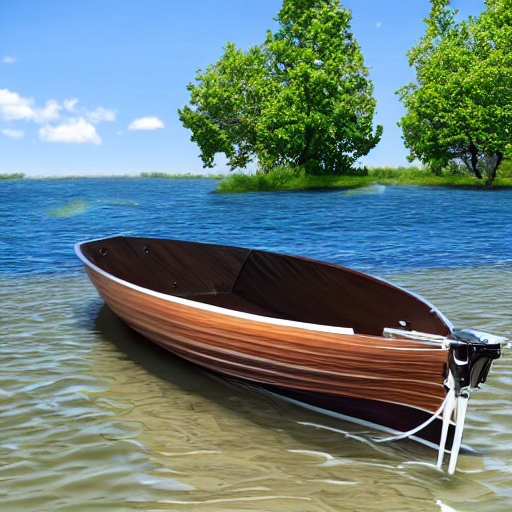

In [ ]:
agent.run("generate an image of a boat in the water")

The agent has access to many tools, which we can find in the `agent.toolbox`:

In [ ]:
agent.toolbox

{'document_qa': PreTool(task='document-question-answering', description='This is a tool that answers a question about an document (pdf). It takes an input named `document` which should be the document containing the information, as well as a `question` that is the question about the document. It returns a text that contains the answer to the question.', repo_id=None),
 'image_captioner': PreTool(task='image-captioning', description='This is a tool that generates a description of an image. It takes an input named `image` which should be the image to caption, and returns a text that contains the description in English.', repo_id=None),
 'image_qa': PreTool(task='image-question-answering', description='This is a tool that answers a question about an image. It takes an input named `image` which should be the image containing the information, as well as a `question` which should be the question in English. It returns a text that is the answer to the question.', repo_id=None),
 'image_segmen

Let's go ahead and create our own custom tool. We specify the tool `name`, `description`, `inputs`, and `outputs`.

We create a new tool called the `MeaningOfLifeTool` which inherits from the `Tool` class of the transformers library. The tool accepts a user's `query` and simply returns `"42"`.

We also specify that the tool requires text as an input and will return text in the output.

In [ ]:
from transformers import Tool

class MeaningOfLifeTool(Tool):
    name = 'meaning_of_life_tool'
    description = (
        "This tool is used to find the answer to the meaning of life, the "
        "Universe and Everything. It takes the users 'query' and returns the "
        "answer they are looking for."
    )
    inputs = ['text']
    outputs = ['text']

    def __call__(self, query: str):
        return "42"

meaning_of_life_tool = MeaningOfLifeTool()

We initializing the `OpenAiAgent` again. We provide the same `gpt-3.5-turbo` model and OpenAI API key, but this time we also add our custom `MeaningOfLifeTool` to the `additional_tools` list. This allows the agent to use our custom tool along with the built-in ones.

In [ ]:
agent = OpenAiAgent(
    model='gpt-3.5-turbo',
    api_key=OPENAI_API_KEY,
    additional_tools=[meaning_of_life_tool]
)

Here, we ask our agent (that now includes our custom tool) the question "what is the meaning of life?". The agent then utilizes the `meaning_of_life_tool` to generate and execute the code. The final output, as expected, is 42.

In [ ]:
agent.run("what is the meaning of life?")

==Explanation from the agent==
I will use the following tool: `meaning_of_life_tool` to find the answer to the question.


==Code generated by the agent==
answer = meaning_of_life_tool(query="What is the meaning of life?")
print(f"The answer is {answer}.")


==Result==
The answer is 42.


'42'

There are a lot of tools attached to the agent by default, we can see this by displaying the `agent.toolbox`:

In [ ]:
from transformers.tools.agents import PreTool

for i, (name, tool) in enumerate(agent.toolbox.items()):
    if type(tool) is PreTool:
        print(f"{i+1}: {name} (PreTool)")
    else:
        print(f"{i+1}: {name} (Tool)")

1: document_qa (PreTool)
2: image_captioner (PreTool)
3: image_qa (PreTool)
4: image_segmenter (PreTool)
5: transcriber (PreTool)
6: summarizer (PreTool)
7: text_classifier (PreTool)
8: text_qa (PreTool)
9: text_reader (PreTool)
10: translator (PreTool)
11: image_transformer (PreTool)
12: text_downloader (PreTool)
13: image_generator (PreTool)
14: video_generator (PreTool)
15: meaning_of_life_tool (Tool)


We have **14** prebuilt tools initialized with the `agent` by default.

These tools all add additional text (descriptions explaining what the tool is) to our prompts, meaning we have more input tokens and therefore slow down our LLM and spend more money on each prompt. We can see these added descriptions in the `description` attribute of the tools:

In [ ]:
agent.toolbox

{'document_qa': PreTool(task='document-question-answering', description='This is a tool that answers a question about an document (pdf). It takes an input named `document` which should be the document containing the information, as well as a `question` that is the question about the document. It returns a text that contains the answer to the question.', repo_id=None),
 'image_captioner': PreTool(task='image-captioning', description='This is a tool that generates a description of an image. It takes an input named `image` which should be the image to caption, and returns a text that contains the description in English.', repo_id=None),
 'image_qa': PreTool(task='image-question-answering', description='This is a tool that answers a question about an image. It takes an input named `image` which should be the image containing the information, as well as a `question` which should be the question in English. It returns a text that is the answer to the question.', repo_id=None),
 'image_segmen

If we don't plan on using them, there's no reason for us to keep all of these tools in our agent. We can remove them like so:

In [ ]:
del_list = []

for name, tool in agent.toolbox.items():
    if type(tool) is PreTool:
        del_list.append(name)

# pop the tools identified
for name in del_list:
    del agent.toolbox[name]

# now lets see how much added text will be added to our prompts
agent.toolbox

{'meaning_of_life_tool': <__main__.MeaningOfLifeTool at 0x7fef6e90fca0>}

Leaving us with only the custom `meaning_of_life_tool` that we created.

In this notebook, we utilized OpenAI's `gpt-3.5-turbo` with HF agents and demoed how to create custom tools. We recognized that while the toolbox's predefined tools provide various capabilities, they also add extra text to our prompts, potentially slowing the language model and increasing cost. To optimize performance and cost, we removed unneeded predefined tools from the toolbox.

This notebook is a simple intro to custom tools in HF agents.

---